In [1]:
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
import time
import matplotlib.pyplot as plt
import time
import random
import pandas as pd

#Set the seed for reproducibility
np.random.seed(7)
random.seed(7)

In [2]:
def add_features(df):
    df['month'] = df['PRICES'].dt.month - 1
    df['day'] = df['PRICES'].dt.day - 1
    df['year'] = df['PRICES'].dt.year
    df['day_of_week'] = df['PRICES'].dt.dayofweek
    df['day_of_week'] = df['day_of_week'].astype(int) 
    df = df.drop(columns=["PRICES"])
    return df

train = pd.read_excel("train.xlsx", parse_dates=['PRICES'])
val = pd.read_excel("validate.xlsx", parse_dates=['PRICES'])
train = add_features(train)
val = add_features(val)
train.head()

,Hour 01,Hour 02,Hour 03,Hour 04,Hour 05,Hour 06,Hour 07,Hour 08,Hour 09,Hour 10,...,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23,Hour 24,month,day,year,day_of_week
0,24.31,24.31,21.71,8.42,0.01,0.01,0.02,0.01,0.01,6.31,...,37.99,33.11,37.99,33.00,36.48,30.65,0,0,2007,0
1,16.01,11.00,9.01,7.50,9.00,7.45,16.50,28.01,29.96,39.60,...,59.69,50.09,50.00,36.22,31.09,29.84,0,1,2007,1
2,28.00,24.50,24.15,18.99,15.50,23.11,29.01,39.73,43.81,49.09,...,60.99,55.51,51.77,34.51,39.31,38.05,0,2,2007,2
3,31.01,28.69,27.00,24.20,12.02,27.00,28.00,34.85,41.31,42.03,...,58.99,53.50,44.01,35.00,34.46,31.57,0,3,2007,3
4,22.00,19.50,17.55,15.91,11.40,22.65,27.30,34.00,40.01,45.00,...,53.00,45.91,36.74,29.61,30.61,27.51,0,4,2007,4


In [13]:
class SmartGridEnv(gym.Env):
    def __init__(self, price_data, battery_capacity=50, max_power=25, efficiency=0.9):
        super(SmartGridEnv, self).__init__()

        self.price_data = price_data
        self.battery_capacity = battery_capacity
        self.max_power = max_power
        self.efficiency = efficiency
        self.action_space = gym.spaces.Discrete(51, start=-25) 
        self.time_constraint = 6
        self.battery_time_constraint = 20
        self.initialize_params()

    def initialize_params(self):
        self.current_step = 0
        self.current_month = 0
        self.current_day = 0
        self.current_hour = 0
        self.day_of_week = int(self.price_data.iloc[self.current_step]['day_of_week'])
        self.current_battery = 20
        self.current_price = self.price_data.iloc[self.current_step, self.current_hour]
        self.buy_price = 0
        self.available = True
        #self.discretize_price(self.current_price)
        #int(self.current_price > 2*self.buy_price)
        self.current_state = tuple([self.discretize_price(self.current_price), int(self.current_price > 2*self.buy_price)])
        self.state_space = [12, 2, self.action_space.n]
        self.done = False
        self.profit = 0 
        
    def car_available(self):
        if self.current_hour == 7:
            available = np.random.uniform(0, 1) < 0.5
        else:
            available = True
        return available

    def discretize_price(self, price):
        if price < 1:
            return 0
        elif price >= 100:
            return 11
        else:
            return int(price // 10) + 1

    def price_diff(self, window=4):
        # return if current price > 2x average last 4 hours
        window -= 1
        if self.current_hour >= window:
            start = self.current_hour - window
            end = self.current_hour
            prices = self.price_data.iloc[self.current_step, start:end]
            avg_price = prices.mean()

            if self.current_price <=  0.5 * avg_price:
                return 1
        return 0
            
    def rsi(self, window=4):
        window -= 1
        if self.current_hour >= window:
            eps = 1e-6
            start = self.current_hour - window
            end = self.current_hour + 1
            
            prices = self.price_data.iloc[self.current_step, start:end]
            delta = np.diff(prices, 1)
            
            avg_gain = delta[np.where(delta > 0)].mean() if len(delta[np.where(delta > 0)]) else eps
            avg_loss = delta[np.where(delta < 0)].mean() if len(delta[np.where(delta < 0)]) else eps

            rs = (avg_gain / avg_loss) if avg_gain != abs(avg_loss) else 0
            rsi = 100 - (100 / (1 + rs))

            if rsi < 30:
                return 1 #oversold
            elif rsi > 70:
                return 2 #overbought
        return 0
    
    def update_state(self):
        # If the car is not available, it returns at 6pm with 20kW less
        if self.available == False:
            #print('Car unavailable')
            self.current_hour = 17
            self.current_battery -= 20
        else:
            self.current_hour = int((self.current_hour + 1) % 24)
            if self.current_hour == 0:
                self.current_step += 1
                
        self.current_month = int(self.price_data.iloc[self.current_step]['month'])
        self.current_day = int(self.price_data.iloc[self.current_step]['day'])
        self.day_of_week = int(self.price_data.iloc[self.current_step]['day_of_week'])
        # Update time step and hour
            
        self.current_state = tuple([self.discretize_price(self.current_price), int(self.current_price > 2*self.buy_price)])
        #tuple([self.price_diff(), int(self.current_price > 2*self.buy_price)])   

        # Update state
        # Check if the episode is done (after 3 years of past electricity prices)
        if self.current_step >= len(self.price_data) - 1:
            self.done = True
        
    def to_discrete(self, action):
        mask = np.zeros(self.action_space.n, dtype=np.int8)
        mask[action] = 1
        return self.action_space.sample(mask = mask)

    def reward(self, action, charge_cost):
        reward = -charge_cost + 0.05 * self.current_battery
        return reward
        
    def step(self, action):
        self.available=self.car_available()
        
        # discretize action
        if self.available == True:
            action = self.to_discrete(action) 
        else:
             action = 0

        # charge cost
        energy_rate = self.price_data.iloc[self.current_step, self.current_hour]
        self.current_price = self.price_data.iloc[self.current_step, self.current_hour]
        charge_cost = action if action < 0 else action * 2 
        charge_cost *= energy_rate / 1000

        # update buy_price
        if action > 0:
            self.buy_price = self.current_price
        elif action < 0:
            self.buy_price = 0
        
        # update battery
        actual_charge = np.round(self.efficiency * action).astype(int) if action>0 else np.round(action/self.efficiency).astype(int)
        self.current_battery += actual_charge
        
        # update variables
        self.profit += -charge_cost

        # reward
        reward = self.reward(action, charge_cost)
        
        self.update_state()
        return self.current_state, reward, self.done, self.available

In [4]:
class QAgent():
    def __init__(self, env, discount_rate = 0.9, learning_rate=0.01, epsilon=0.8):
        self.env = env
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.Qtable = np.zeros(env.state_space)
        self.profit = []

    def mask(self):
        # 7 am constraint  
        if self.env.current_hour == self.env.time_constraint and self.env.current_battery >= self.env.battery_time_constraint:
            lower_bound = min(np.ceil((self.env.battery_time_constraint- self.env.current_battery)*0.9), self.env.max_power)
            upper_bound =  min(np.floor((self.env.battery_capacity-self.env.current_battery)/0.9), self.env.max_power)
            mask_range = (lower_bound, upper_bound)
        elif self.env.current_hour == self.env.time_constraint and self.env.current_battery < self.env.battery_time_constraint:
            lower_bound = min(np.ceil((self.env.battery_time_constraint-self.env.current_battery)/0.9), self.env.max_power)
            upper_bound =  min(np.floor((self.env.battery_capacity-self.env.current_battery)/0.9), self.env.max_power)
            mask_range = (lower_bound, upper_bound)
        else: 
            lower_bound = max(np.ceil(-(self.env.current_battery)*0.9), -self.env.max_power)
            upper_bound = min(np.floor((self.env.battery_capacity - self.env.current_battery)/0.9), self.env.max_power)
            mask_range = (lower_bound, upper_bound)
        
        # construct boolean mask_vector
        mask = np.arange(self.env.action_space.start, self.env.action_space.start + self.env.action_space.n)
        mask = np.where((mask >= mask_range[0]) & (mask <= mask_range[1]), True, False)
        return mask

    def select_action_epsilon_greedy(self, current_state):
        mask = self.mask()
        #pick random action
        if (np.random.uniform(0,1) > 1-self.epsilon) or (np.all(self.Qtable[current_state] == 0)):
            action = np.random.choice(np.arange(env.action_space.n)[mask])
        
        #pick greedy action
        else:
            max_action = np.argmax(self.Qtable[current_state][mask])
            action = np.where(mask)[0][0] + max_action
        
        return action

    def train(self, simulations = 100, epsilon = 0.05):
        for i in range(simulations):
            self.epsilon = max(0.05, self.epsilon - 0.05)
            while not self.env.done:    
                current_state = tuple(self.env.current_state)
                action = self.select_action_epsilon_greedy(current_state)
                next_state, reward, done, available= env.step(action)
                next_state_mask = self.mask()

                # update Q_values
                Q_target = (reward + self.discount_rate*np.max(self.Qtable[next_state][next_state_mask]))
                delta = self.learning_rate * (Q_target - self.Qtable[current_state][action])
                self.Qtable[current_state][action] = self.Qtable[current_state][action] + delta   
            
            self.profit.append(env.profit)
            self.env.initialize_params()
            
    def predict(self, state):
        mask = self.mask()
        max_action = np.argmax(self.Qtable[state][mask])
        action = np.where(mask)[0][0] + max_action
        return action

    def plot_profits(self):
        plt.plot(agent.profit)
        plt.xlabel('Epochs')  
        plt.ylabel('Profit')  
        plt.title("Cost per epoch") 

# env = SmartGridEnv(train[:365])
# agent = QAgent(env)
# agent.train(simulations=50)
# agent.plot_profits()

In [8]:
agent.Qtable[0, 0]

array([0.02357917, 0.01666331, 0.        , 0.00768853, 0.05938606,
       0.07814599, 0.05991414, 0.06433369, 0.10852057, 0.02908208,
       0.12121441, 0.21074179, 0.17980348, 0.05574936, 0.11567938,
       0.25936192, 0.13833677, 0.10149277, 0.22111089, 2.36057835,
       0.30115618, 0.45869704, 0.52276019, 0.44847145, 2.03728973,
       0.24888694, 0.47260156, 0.37340328, 0.41265633, 0.50471151,
       0.58856099, 0.38393294, 0.43978191, 0.39299628, 0.5318787 ,
       0.46746755, 0.417636  , 0.47207825, 0.58328357, 0.49476536,
       1.70450161, 0.36612484, 0.37890674, 0.42267025, 0.41831372,
       0.40591145, 0.41367292, 0.46125141, 0.42799633, 0.29510865,
       0.31193746])

In [13]:
eval_env = SmartGridEnv(val)
agent.env = eval_env

while not agent.env.done:
    current_state = tuple(agent.env.current_state)
    action = agent.predict(current_state)
    print(f"at time {agent.env.current_hour +  1} agent transacts {agent.env.to_discrete(action)} KWh, battery is {agent.env.current_battery}")
    next_state, reward, done, available = agent.env.step(action)

print("Profit on validation set: ", agent.env.profit)
# agent.Qtable[6, 0,]

at time 1 agent transacts 0 KWh, battery is 0
at time 2 agent transacts 24 KWh, battery is 0
at time 3 agent transacts 5 KWh, battery is 22
at time 4 agent transacts 0 KWh, battery is 26
at time 5 agent transacts 0 KWh, battery is 26
at time 6 agent transacts -9 KWh, battery is 26
at time 7 agent transacts 22 KWh, battery is 16
at time 8 agent transacts -10 KWh, battery is 36
at time 9 agent transacts -4 KWh, battery is 25
at time 10 agent transacts -9 KWh, battery is 21
at time 11 agent transacts -4 KWh, battery is 11
at time 12 agent transacts 4 KWh, battery is 7
at time 13 agent transacts 0 KWh, battery is 11
at time 14 agent transacts -2 KWh, battery is 11
at time 15 agent transacts 3 KWh, battery is 9
at time 16 agent transacts -10 KWh, battery is 12
at time 17 agent transacts 0 KWh, battery is 1
at time 18 agent transacts 0 KWh, battery is 1
at time 19 agent transacts 5 KWh, battery is 1
at time 20 agent transacts 1 KWh, battery is 5
at time 21 agent transacts 2 KWh, battery is 6

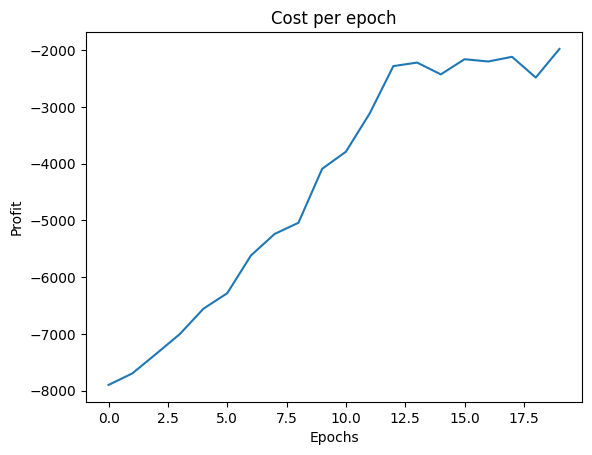

In [14]:
class SimpleQAgent(QAgent):
    def __init__(self):
        super().__init__(env)
        self.Qtable = np.zeros((12, 2, 9))
        self.actions = np.array([0, 5, 10, 15, 25, 35, 40, 45, 50])
        self.discount_rate = 0.8
        self.learning_rate = 0.5
        self.epsilon = 0.7
        
    def mask(self):        
        if self.env.current_hour == self.env.time_constraint:
            return np.array([self.env.current_battery >= np.ceil((20 + 25) / 0.9),
                             self.env.current_battery >= np.ceil((20 + 20) / 0.9),
                             self.env.current_battery >= np.ceil((20 + 15) / 0.9),
                             self.env.current_battery >= np.ceil((20 + 10) / 0.9),
                             self.env.current_battery >= 20,
                             (self.env.current_battery <= np.ceil(50 - 10 / 0.9) and self.env.current_battery >= np.ceil((20 - 10) / 0.9)),
                             (self.env.current_battery <= np.ceil(50 - 15 / 0.9) and self.env.current_battery >= np.ceil((20 - 15) / 0.9)),
                             (self.env.current_battery <= np.ceil(50 - 20 / 0.9) and self.env.current_battery >= np.ceil((20 - 20 + 1) / 0.9)),
                             self.env.current_battery <= np.ceil(50 - 25 / 0.9)])
        else:
            return np.array([self.env.current_battery >= np.ceil(25 / 0.9),
                             self.env.current_battery >= np.ceil(20 / 0.9),
                             self.env.current_battery >= np.ceil(15 / 0.9),
                             self.env.current_battery >= np.ceil(10 / 0.9),
                             True, 
                             self.env.current_battery <= np.ceil(50 - 10 / 0.9),
                             self.env.current_battery <= np.ceil(50 - 15 / 0.9),
                             self.env.current_battery <= np.ceil(50 - 20 / 0.9),
                             self.env.current_battery <= np.ceil(50 - 25 / 0.9)])

    def select_action_epsilon_greedy(self, current_state):
        mask = self.mask()
        #pick random action
        if (np.random.uniform(0,1) > 1-self.epsilon) or (np.all(self.Qtable[current_state] == 0)):
            action = np.random.choice(self.actions[mask])   
        #pick greedy action
        else:
            max_action = np.argmax(np.where(mask, self.Qtable[current_state], -100))
            action = self.actions[max_action]     
        return action

    def train(self, simulations = 100, epsilon = 0.05):
        for i in range(simulations):
            # learning_rate / epsilon decay
            self.epsilon = max(0.05, self.epsilon - 0.05)
            self.learning_rate *= 0.90
            
            while not self.env.done:
                current_state = tuple(self.env.current_state)
                action = self.select_action_epsilon_greedy(current_state)
                next_state, reward, done, available= env.step(action)
                next_state_mask = self.mask()

                if self.env.available:
                    action = np.argwhere(self.actions == action)[0][0]
                else:
                    # set action to do nothing if unavailable
                    action = np.argwhere(self.actions == 25)[0][0]
                    
                # update Q_values
                Q_target = (reward + self.discount_rate*np.max(self.Qtable[next_state][next_state_mask]))                
                delta = self.learning_rate * (Q_target - self.Qtable[current_state][action])
                self.Qtable[current_state][action] = self.Qtable[current_state][action] + delta 
            
            self.profit.append(env.profit)
            self.env.initialize_params()

    def predict(self, state):
        mask = self.mask()
        max_action = np.argmax(np.where(mask, self.Qtable[current_state], -100))
        action = self.actions[max_action] 
        return action

env = SmartGridEnv(train)
agent = SimpleQAgent()
agent.train(simulations=20)
agent.plot_profits()

## Eval

In [18]:
eval_env = SmartGridEnv(val)
agent.env = eval_env

while not agent.env.done:
    current_state = tuple(agent.env.current_state)
    action = agent.predict(current_state)
    print(f"at time {agent.env.current_hour +  1} agent transacts {agent.env.to_discrete(action)} KWh, battery is {agent.env.current_battery}")
    next_state, reward, done, available = agent.env.step(action)

print("Profit on validation set: ", agent.env.profit)

at time 1 agent transacts 15 KWh, battery is 20
at time 2 agent transacts 0 KWh, battery is 34
at time 3 agent transacts 0 KWh, battery is 34
at time 4 agent transacts 0 KWh, battery is 34
at time 5 agent transacts 0 KWh, battery is 34
at time 6 agent transacts 0 KWh, battery is 34
at time 7 agent transacts 0 KWh, battery is 34
at time 8 agent transacts 0 KWh, battery is 34
at time 18 agent transacts 0 KWh, battery is 14
at time 19 agent transacts 0 KWh, battery is 14
at time 20 agent transacts 0 KWh, battery is 14
at time 21 agent transacts 10 KWh, battery is 14
at time 22 agent transacts 0 KWh, battery is 23
at time 23 agent transacts 0 KWh, battery is 23
at time 24 agent transacts 0 KWh, battery is 23
at time 1 agent transacts 0 KWh, battery is 23
at time 2 agent transacts 0 KWh, battery is 23
at time 3 agent transacts 0 KWh, battery is 23
at time 4 agent transacts 0 KWh, battery is 23
at time 5 agent transacts 0 KWh, battery is 23
at time 6 agent transacts 0 KWh, battery is 23
at t

In [23]:
agent.Qtable[4]

array([[3.62842751, 3.62860446, 3.94531557, 3.87772873, 5.47071261,
        4.0227995 , 3.76243786, 3.67710313, 3.42336923],
       [4.35039752, 3.79047185, 3.55213306, 3.28373631, 3.33226848,
        4.59272411, 2.68200592, 2.61211173, 2.33593135]])

In [360]:
indices = np.arange(24)
avg_prices = np.array([train.iloc[:, i].mean() for i in range(24)])
len(indices[avg_prices > 100]), avg_prices

(0,
 array([38.83812044, 33.99355839, 30.05389599, 24.88116788, 23.12443431,
        28.80376825, 36.65219891, 50.54479015, 56.92439781, 63.9117427 ,
        67.13242701, 70.88373175, 64.99515511, 61.6182573 , 58.98109489,
        54.61488139, 53.98165146, 60.16250912, 67.46607664, 62.43669708,
        58.46425182, 50.28571168, 50.45126825, 45.25933394]))

In [106]:
np.array([train.iloc[:, i].mean() for i in range(24)])

array([38.83812044, 33.99355839, 30.05389599, 24.88116788, 23.12443431,
       28.80376825, 36.65219891, 50.54479015, 56.92439781, 63.9117427 ,
       67.13242701, 70.88373175, 64.99515511, 61.6182573 , 58.98109489,
       54.61488139, 53.98165146, 60.16250912, 67.46607664, 62.43669708,
       58.46425182, 50.28571168, 50.45126825, 45.25933394])

In [104]:
env = SmartGridEnv(train)
env.current_hour = 4

env.rsi(), env.price_diff()

Hour 02    24.31
Hour 03    21.71
Hour 04     8.42
Name: 0, dtype: float64 18.146666666666665


(1, 0)